## GET PACKAGES

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from string import punctuation

from sklearn.cluster import MiniBatchKMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
from sklearn.feature_extraction import text
from tqdm import tqdm, tqdm_notebook

import json

In [2]:
input_path = '../data/'
train_dataframe = pd.read_csv(input_path + 'opioid_tweets.csv')

In [46]:
train_dataframe.head(500)

,id,tweet_id,content,created_at,fav_count,url_present,user_name,followers_count,friends_count,user_description
0,1,1.18237E+18,"Boston Police, Public Health Officials To Trea...",10/10/19,662,TRUE,SaraCarterDC,836793,4656.0,"@FoxNews Contributor, award winning National S..."
1,2,1.18212E+18,Three #Chinese nationals were charged last wee...,10/10/19,302,TRUE,EpochTimes,134594,102.0,"An independent, award-winning voice in print &..."
2,3,1.18236E+18,Three #Chinese nationals were charged with imp...,10/10/19,164,TRUE,EpochTimes,134594,102.0,"An independent, award-winning voice in print &..."
3,4,1.18272E+18,Boston is using a chemical warfare device to h...,10/11/19,0,TRUE,BUSPH,27642,2202.0,The official Twitter of Boston University Scho...
4,5,1.18272E+18,This makes no sense given what President Trump...,10/11/19,0,TRUE,FlagHiApp,1893,4547.0,"FlagHi™ calculates how temperature, elevation ..."
...,...,...,...,...,...,...,...,...,...,...
495,604178,1.1892E+18,@tcpineset First off I was not that first year...,10/29/19,0,FALSE,Codeine_Dreams_,1205,1099.0,Social Loner. 🌱 Distant Clinger.👋🏾 ♉️🌞♍️🌛✌🏾#FM...
496,604179,1.1892E+18,Not having to go on SoundCloud to listen to co...,10/29/19,1,FALSE,amiiiralias,298,289.0,NaN
497,32165,1.18235E+18,We catering promethazine codeine cough syzurp ...,10/10/19,4,FALSE,MalikAtwater,475,203.0,Nuck up if you buck up
498,60553,1.18248E+18,Nobody: \n\nMe randomly: OXYCONTIN WHAT I PISS,10/11/19,0,FALSE,AlmightySelma,686,597.0,new twitter. ♈️


In [21]:
# Creating a list of stopwords
stops = stopwords.words('english')
# Add stop variants without single quotes
no_quotes = [re.sub(r'\'','',word) for word in stops if "'" in word]
my_stop_words = ["codeine", "hydrocodone", "morphine", "oxycodone", "hydromorphone", "fentanyl", "oxycontin", "vicodin", "percocet"]
stops.extend(no_quotes)
stops.extend(my_stop_words)

## CLEANING TIME XD

In [22]:
def clean_string(string):
    # remove HTML entities
    temp = re.sub(r'\&\w*;','', string)
    # remove @user
    temp = re.sub(r'@(\w+)','', temp)
    # remove links
    temp = re.sub(r'(http|https|ftp)://[a-zA-Z0-9\\./]+','', temp)
    # lowercase
    temp = temp.lower()
    # remove hashtags
#     temp = re.sub(r'#(\w+)','', temp)
    # remove repeating characters
    temp = re.sub(r'(.)\1{1,}',r'\1\1', temp)
    # remove non-letters
    temp = re.sub("[^a-zA-Z]"," ", temp)
    # remove anything that is less than two characters
    temp = re.sub(r'\b\w{1,2}\b','',temp)
    # remove multiple spaces
    temp = re.sub(r'\s\s+', ' ', temp)
    return temp

def str_preprocess(string):
    stemmer = PorterStemmer()
    # removing punctuation
    removed_punc = ''.join([char for char in string if char not in punctuation])
    # removing stopwords
    cleaned = [stemmer.stem(word.lower()) for word in removed_punc.split(' ') if word not in stops]
    return ' '.join(cleaned)

In [23]:
#my_stop_words = text.ENGLISH_STOP_WORDS.union(["codeine", "hydrocodone", "morphine", "oxycodone", "hydromorphone", "fentanyl", "oxycontin", "vicodin", "percocet"])
docs = train_dataframe.content.astype(str)

In [24]:
cleaned_frame = docs.apply(clean_string).apply(str_preprocess)

In [25]:
cleaned_frame

0        boston polic public health offici treat biowea...
1        three chines nation charg last week import dis...
2        three chines nation charg import distribut par...
3           boston use chemic warfar devic help fight via 
4        make sens given presid trump alreadi done cont...
                               ...                        
42949    thank got motrin tri naproxen excedrin kid go ...
42950     one year husband dress realli fat elvi made c...
42951     fractur growth plate doctor gave year later c...
42952     mess fuck like real imagin recreat zero toler...
42953    anyon oxi gasp last two like fuckin gold dust ...
Name: content, Length: 42954, dtype: object

In [26]:
td_idf_vec = TfidfVectorizer(stop_words=my_stop_words, max_features = 20000)
X = td_idf_vec.fit_transform(cleaned_frame)
X_norm = normalize(X)
X_arr = X_norm.toarray()

In [27]:
# SVD IS PREFERRED HERE AND TRUNCATED SVD WORKS ON TERM COUNT/TF-IDF MATRICES AS RETURNED BY THE VECTORIZER
# THIS IS LATENT SEMANTIC ANALYSIS
data_svd = TruncatedSVD(n_components = 250) #BEST VALUE FOR TIME-COMPLEXITY IS N=250
response_svd = data_svd.fit_transform(X_arr)
#var_explained = data_svd.explained_variance_ratio_.sum() # This was used to determine the percent of variance explained by additional n_components

## K-Cluster Hyperparam Testing
Going to test the range of k that makes this k means have the best score
This is proving to be harder than it seems, after getting rid of all the stopwords, links, and @user symbols, the clutering score is starting to get a little fuzzy. I don't think there is an optimal way to cluster them??

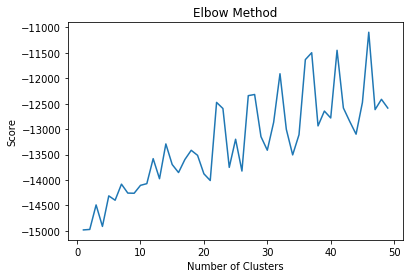

In [11]:
# TESTING FOR THE OPTIMAL NUMBER OF K CLUSTERS FOR THE KMEANS MODEL
number_clusters = range(1, 50) # BEST ONE WAS 4-7
max_iter_number = range(1, 1000, 100) # BEST ONE WAS 100
kmeans = [MiniBatchKMeans(n_clusters=i, batch_size = 50, init= 'k-means++', max_iter = 100) for i in number_clusters]
score = [kmeans[i].fit(response_svd).score(response_svd) for i in tqdm_notebook(range(len(kmeans)))]
# PLOTTING ELBOW PLOT
plt.plot(number_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

This is really confusing for me as there seems to be no plateau.

I'm going to look at the other results here. These are from the non-stemmed and uncleaned dataset, the elbow plots are easier to read and there is less variance in the data.

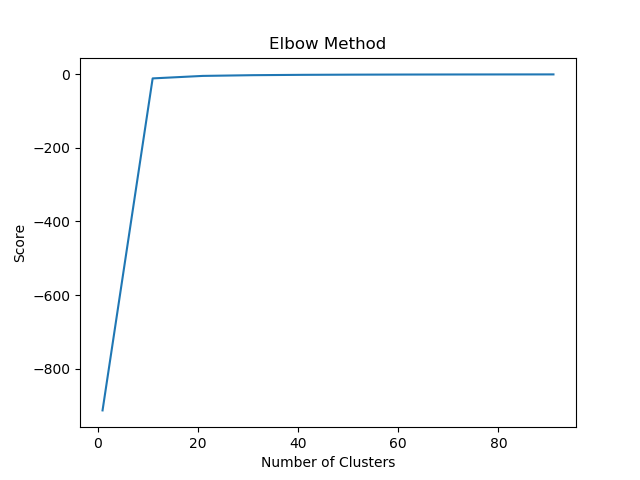

In [12]:
Image(filename='../clustering/Elbow(k_1_100_10).png') 

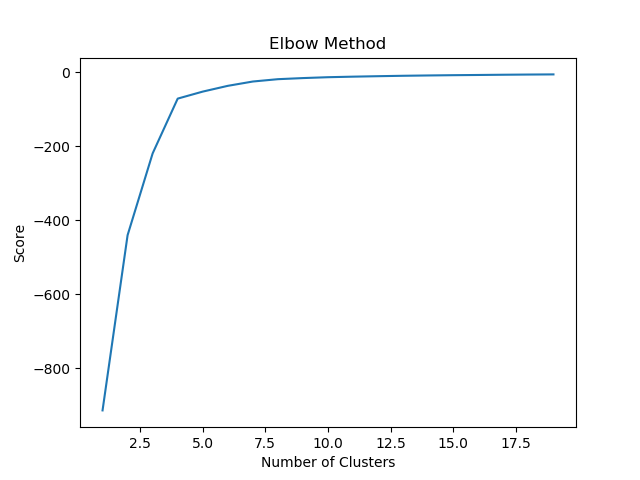

In [13]:
Image(filename='../clustering/Elbow(k_1_20).png')

In [109]:
k_value = 100
kmeans = MiniBatchKMeans(n_clusters=k_value, batch_size = 100, init= 'k-means++', max_iter = 100)
fitted_values = kmeans.fit(response_svd)
predicted_values = kmeans.predict(response_svd)

In [110]:
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = td_idf_vec.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs
dfs = get_top_features_cluster(X_arr, predicted_values, 15)

IndexError: list index out of range

In [111]:
bad_tweets = [6047, 6048, 472376, 554992, 554993, 554994, 554995, 6047, 80456, 33230, 15809, 6179, 6141, 6009, 5878, 17160]
train = train_dataframe[train_dataframe.id.apply(lambda x: x.isnumeric())].astype({'id':'int32'})
bad_content = train[train.id.isin(bad_tweets)]

In [112]:
predicted_values[[652,  2378,  2445,  2476,  2477,  2558,  2587,  3523,  5067, 13495, 18144, 30652, 30653, 30654, 30655]]

array([12, 12, 12, 43, 70, 12, 12, 54, 76, 76, 70, 43, 43, 43, 43],
      dtype=int32)

Following is a Latent Dirchelet Allocation (LDA) topic summary:

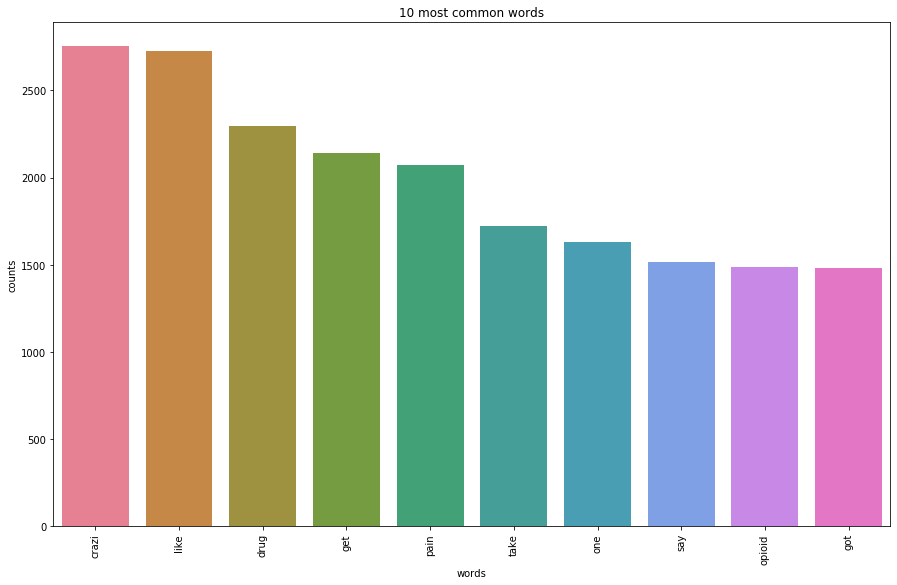

In [16]:
# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer

# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()# Initialise the count vectorizer with the English stop words
    
count_vectorizer = CountVectorizer(stop_words=my_stop_words)
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(cleaned_frame)
# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [17]:
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
get pain like take want feel one day got need

Topic #1:
like crazi got stripper joint song drink die fuck need

Topic #2:
drug opioid call overdos someth heroin china painkil kill death

Topic #3:
opioid china one peopl heroin took love use drug crack

Topic #4:
crazi say drug maker angel enough year take time million


In [18]:
predict = lda.transform(count_data)
print(predict)

[[0.02233343 0.02233991 0.40045844 0.02271636 0.53215187]
 [0.02039054 0.02010332 0.02054438 0.41789196 0.5210698 ]
 [0.02243598 0.0223102  0.02305432 0.36252999 0.56966952]
 ...
 [0.79446791 0.01883777 0.01882715 0.14905964 0.01880752]
 [0.9191064  0.02048467 0.02012552 0.02019007 0.02009335]
 [0.82367519 0.01715707 0.01670991 0.12564964 0.01680818]]
